# Tutorial: context aware learning of multiple modalities with mmcontext

## Contents of Tutorial

This tutorial demonstrates how to use the mmcontext package to preprocess single-cell data. We'll walk through the steps of:

**Preprocessing**:
1. Loading the Dataset
2. Generating Embeddings
3. Normalizing Embeddings
4. Aligning Embeddings
5. Constructing the Dataset
6. Creating a Data Loader

**Model fitting**:
1. Initialize the model
2. Configure the loss
3. Train the model

### Preprocessing
#### 1. Loading the Dataset

The input data has to be an {class}`anndata.AnnData` object. First, we'll load the example dataset provided in data/small_cellxgene.h5ad. It is derived from the cellxgene census {cite:p}`czi2023cz` and contains cells of various tissues and celltypes from different studys. The scvi embedding included is provided by cellxgene and contains embeddings computed with the scvi variational autoencoder trained on the cellxgene corpus. It is a custom made dataset that contains data from various tissues originating from different datasets.

In [94]:
# Import necessary libraries
import anndata
import scanpy as sc

data_path = "../../data/demo/small_cellxgene.h5ad"
# Load the dataset
adata = anndata.read_h5ad(data_path)
# Display basic information about the dataset
print(adata)

AnnData object with n_obs × n_vars = 5600 × 1000
    obs: 'soma_joinid', 'donor_id', 'disease', 'sex', 'dataset_id', 'cell_type', 'assay', 'tissue', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'is_primary_data'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
    obsm: 'metadata_tissue_assay_cell_type', 'scvi'


In [95]:
# Log transformation for reconstruction
sc.pp.log1p(adata)

In [96]:
from mmcontext.pp.utils import split_anndata, remove_entries, consolidate_low_frequency_categories

# split anndata into train and test
train_adata, test_adata = split_anndata(adata, train_size=0.8)
remove_entries(train_adata)
remove_entries(test_adata)
# remove cells and datasets with less than 5 appearances
train_adata = consolidate_low_frequency_categories(
    train_adata, columns=["cell_type", "dataset_id"], threshold=5, remove=True
)
# remove cells and datasets with less than 5 appearances
test_adata = consolidate_low_frequency_categories(
    test_adata, columns=["cell_type", "dataset_id"], threshold=5, remove=True
)

mmcontext.pp.utils - INFO - No cells with zero variance found.
mmcontext.pp.utils - INFO - No cells with zero variance found.


c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\scanpy\preprocessing\_simple.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\scanpy\preprocessing\_simple.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


#### 2. Generate Embeddings

We will generate context embeddings based on the categorical metadata fields cell_type and tissue using the {class}`mmcontext.pp.CategoryEmbedder` class.
The method is based on creating an embedding of the individual categories of a cell with a text model. The `embeddings_file_path` points to a dictionary that contains embeddings for a range of cell types and tissues from the cellxgene corpus, thereby allowing the method to work without needing an API call. Only if some categories are not found in the dictionary the api will be used. If only a few are unknown, these will just be filled with a zero embedding. The `unkown_threshold` parameter controls how many new categories are needed to use the API. For that of course an API Key will be needed, which has to be set as an environmental variable "OPENAI_API_KEY". 

We will use the precomputed data embeddings stored in `adata.obsm['scvi']` as our data embeddings

In [97]:
# Import the CategoryEmbedder class
from mmcontext.pp import CategoryEmbedder, Embedder

# Specify the categories to embed
categories = ["cell_type"]
one_hot = False
# Initialize the CategoryEmbedder
category_embedder = CategoryEmbedder(
    metadata_categories=categories,
    model="text-embedding-3-small",
    combination_method="concatenate",
    embeddings_file_path="../../data/emb_dicts/category_embeddings_text-embedding-3-small_metadata_embeddings.pkl.gz",
    one_hot=one_hot,
)
# Initialize the Embedder without embedders
embedder = Embedder(context_embedder=category_embedder, data_embedder=None)

# Create embeddings using external embeddings
for adata in [train_adata, test_adata]:
    embedder.create_embeddings(adata, data_embeddings=adata.obsm["scvi"])
    # Confirm the shape of the context embeddings
    print("Context Embeddings Shape:", adata.obsm["c_emb"].shape)
    print("Data Embeddings Shape:", adata.obsm["d_emb"].shape)

mmcontext.pp.context_embedder - INFO - Loaded embeddings from file.
mmcontext.pp.context_embedder - INFO - Embeddings dictionary contains the following categories: dict_keys(['cell_type', 'tissue', 'assay']) with a total of 947 elements.
mmcontext.pp.embedder - INFO - Using external data embeddings provided.
mmcontext.pp.embedder - INFO - Creating context embeddings...
mmcontext.pp.context_embedder - INFO - Embeddings for 'cell_type' stored in adata.obsm['cell_type_emb']
mmcontext.pp.context_embedder - INFO - Combined context embeddings stored in adata.obsm['c_emb']
Context Embeddings Shape: (4279, 1536)
Data Embeddings Shape: (4279, 50)
mmcontext.pp.embedder - INFO - Using external data embeddings provided.
mmcontext.pp.embedder - INFO - Creating context embeddings...
mmcontext.pp.context_embedder - INFO - Embeddings for 'cell_type' stored in adata.obsm['cell_type_emb']
mmcontext.pp.context_embedder - INFO - Combined context embeddings stored in adata.obsm['c_emb']
Context Embeddings 

#### 3. Normalize Embeddings 

Now that the embeddings are created and stored in the adata object we can apply normalization. We will use the {class}`mmcontext.pp.MinMaxNormalizer` here. 

In [98]:
# Import the MinMaxNormalizer class
from mmcontext.pp import MinMaxNormalizer

# Initialize the MinMaxNormalizer
normalizer = MinMaxNormalizer()
# Normalize the embeddings
for adata in [train_adata, test_adata]:
    normalizer.normalize(adata)

    # Confirm that normalized embeddings are stored
    print("Normalized Data Embeddings Shape:", adata.obsm["d_emb_norm"].shape)
    print("Normalized Context Embeddings Shape:", adata.obsm["c_emb_norm"].shape)

mmcontext.pp.embedding_normalizer - INFO - Normalizing embeddings using min-max normalization...
Normalized Data Embeddings Shape: (4279, 50)
Normalized Context Embeddings Shape: (4279, 1536)
mmcontext.pp.embedding_normalizer - INFO - Normalizing embeddings using min-max normalization...
Normalized Data Embeddings Shape: (930, 50)
Normalized Context Embeddings Shape: (930, 1536)


#### 4. Aligning Embeddings

After normalization we will now use a {class}`mmcontext.pp.DimAligner` to make sure the dimensions of both data and context embeddings are equal, as this will be nescessary for the model. We will use the {class}`mmcontext.pp.PCAReducer` for this. If embeddings are larger than target latent dimension, they will be reduced via PCA. If there are smaller, padding with zeros will be applied. If using the {class}`mmcontext.pp.PCAReducer`, you can evaluate the principal components with some plots and metrics.

In [99]:
from omegaconf import DictConfig

# Create a DictConfig object for the configuration
config = DictConfig(
    {
        "evaluate_pca": True,
        "save_path": "pca_eval_oh",
        "scree_plot": True,
        "cumulative_variance_plot": True,
        "loadings_heatmap": True,
        "loadings_heatmap_options": {
            "threshold": 0,  # Only include loadings above this threshold
            "top_n_components": 64,  # Number of principal components to include in the heatmap
            "top_n_variables": 1000,  # Number of variables to display in the heatmap
        },
    }
)
# Configuration dictionary for PCA evaluation

if config.evaluate_pca and one_hot:
    config.one_hot_order = adata.uns["one_hot_order"]

In [100]:
# Import the PCAReducer class
from mmcontext.pp import PCAReducer

# Initialize the PCAReducer with the desired latent dimension
latent_dim = 64
aligner = PCAReducer(latent_dim=latent_dim, config=config)

# Align the embeddings
for adata in [train_adata, test_adata]:
    aligner.align(adata)

    # Confirm that aligned embeddings are stored
    print("Aligned Data Embeddings Shape:", adata.obsm["d_emb_aligned"].shape)
    print("Aligned Context Embeddings Shape:", adata.obsm["c_emb_aligned"].shape)

mmcontext.pp.dim_aligner - INFO - one_hot_order not provided. Using default feature indices.
mmcontext.pp.dim_aligner - INFO - Applied threshold: 0
mmcontext.pp.dim_aligner - INFO - Selected top 1000 variables based on importance.
mmcontext.pp.dim_aligner - INFO - Loadings heatmap saved to pca_eval_oh\loadings_heatmap.png
mmcontext.pp.dim_aligner - INFO - Loadings heatmap generation complete.
Aligned Data Embeddings Shape: (4279, 64)
Aligned Context Embeddings Shape: (4279, 64)
mmcontext.pp.dim_aligner - INFO - one_hot_order not provided. Using default feature indices.
mmcontext.pp.dim_aligner - INFO - Applied threshold: 0
mmcontext.pp.dim_aligner - INFO - Selected top 1000 variables based on importance.
mmcontext.pp.dim_aligner - INFO - Loadings heatmap saved to pca_eval_oh\loadings_heatmap.png
mmcontext.pp.dim_aligner - INFO - Loadings heatmap generation complete.
Aligned Data Embeddings Shape: (930, 64)
Aligned Context Embeddings Shape: (930, 64)


#### 5. Constructing the Dataset

Finally, we will construct a dataset using the aligned embeddings, suitable for training models with PyTorch.

In [101]:
# Import the DataSetConstructor class
from mmcontext.pp import DataSetConstructor

# The sequence length for the dataset. Since attention mechanisms will be used, samples can be grouped into sequences to perform attention within the sequence.
seq_length = 32
batch_size = 16
# Initialize the DataSetConstructor
train_dataset_constructor = DataSetConstructor(
    out_emb_keys={"data_embedding": "d_emb", "context_embedding": "c_emb"},
    use_raw=True,
    chunk_size=seq_length * batch_size,
    batch_size=batch_size,
)
test_dataset_constructor = DataSetConstructor(
    out_emb_keys={"data_embedding": "d_emb", "context_embedding": "c_emb"},
    use_raw=True,
    chunk_size=seq_length * batch_size,
    batch_size=batch_size,
)

# Add the AnnData object to the dataset
train_dataset_constructor.add_anndata(
    train_adata,
    emb_keys={"data_embedding": "d_emb_aligned", "context_embedding": "c_emb_aligned"},
    sample_id_key="soma_joinid",
)
test_dataset_constructor.add_anndata(
    test_adata,
    emb_keys={"data_embedding": "d_emb_aligned", "context_embedding": "c_emb_aligned"},
    sample_id_key="soma_joinid",
)


# Construct the dataset
train_dataset = train_dataset_constructor.construct_dataset(seq_length=seq_length)
test_dataset = test_dataset_constructor.construct_dataset(seq_length=seq_length)

#### 6. Create a Dataloader
Create a pyTorch Dataloader which can be iterated over

In [102]:
from torch.utils.data import DataLoader

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
# For now use the test data as validation data
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Iterate over DataLoader and verify batch shapes
for batch in train_loader:
    data_embeddings = batch["d_emb"]  # Shape: (batch_size, seq_length, embedding_dim)
    context_embeddings = batch["c_emb"]  # Shape: (batch_size, seq_length, embedding_dim)
    sample_ids = batch["sample_id"]  # Shape: (batch_size, seq_length)
    raw_data = batch["raw_data"]  # Shape: (batch_size, seq_length, num_features)

    print(data_embeddings.shape)
    print(context_embeddings.shape)
    print(sample_ids.shape)
    print(raw_data.shape)
    break  # Only need to check the first batch

torch.Size([16, 32, 64])
torch.Size([16, 32, 64])
torch.Size([16, 32])
torch.Size([16, 32, 1000])


### Model fitting
#### 1. Initializing the Model
The {class}`mmcontext.engine.MMContextEncoder` is the main encoder which will be used to create embeddings based on the available data and context embeddings. It's structure is flexible and is build upon torchs {class}`torch.nn.TransformerEncoder` which creates stacks of the {class}`mmcontext.engine.CustomTransformerEncoderLayer` which can be configured to be 

1. To apply self attention (use_self_attention = True)
2. To apply cross attention (use_cross_attention = True)
3. To use both self and cross attention (both True)
4. An MLP only model (both False)

The model takes two matrix inputs, `in_main` and `in_cross`. in_main will be passed through the MLP and optionally the self-attention layers, while in_cross is only used if cross-attention is used. In the end the model outputs embeddings of the same shape as in_main, updated based on the learning objective. The inputs are handled in the {class}`mmcontext.engine.Trainer` in dependancy with the settings used for the loss. 

In [103]:
from mmcontext.engine import MMContextEncoder, ZINBDecoder

hidden_dim = 64
num_layers = 1
num_heads = 1
encoder = MMContextEncoder(
    embedding_dim=latent_dim,  # this has to be the same dimension as the latent dimension of the aligner
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    num_heads=num_heads,
    use_self_attention=False,
    use_cross_attention=False,
    activation="relu",
    dropout=0.1,
)
encoder2 = MMContextEncoder(
    embedding_dim=latent_dim,  # this has to be the same dimension as the latent dimension of the aligner
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    num_heads=num_heads,
    use_self_attention=False,
    use_cross_attention=False,
    activation="relu",
    dropout=0.1,
)
decoder = ZINBDecoder(
    input_dim=latent_dim,
    hidden_dims=[64, 128],
    output_dim=train_adata.shape[1],  # number of genes
)

mmcontext.engine.models - INFO - MMContextEncoder initialized with embedding_dim = 64, num_layers = 1, use_self_attention = False, use_cross_attention = False.
mmcontext.engine.models - INFO - MMContextEncoder initialized with embedding_dim = 64, num_layers = 1, use_self_attention = False, use_cross_attention = False.
ZINBDecoder
mmcontext.engine.models - INFO - ZINBDecoder initialized with input_dim = 64, hidden_dims = [64, 128], output_dim = 1000.


#### 2. Configure the loss
The loss function is a central part of this project. The loss is implemented to be extendable and customizable by having a {class}`mmcontext.engine.LossManager` which you can use to add different losses to and which will be passed to the {class}`mmcontext.engine.Trainer` to compute the total loss (as a weighted average of the components) during Training. The current main implementation of a {class}`mmcontext.engine.LossFunction` is the {class}`mmcontext.engine.ContrastiveLoss`, which is a custom approach to contrastive learning. It's main configuration parameters are `target_mode` and `current_mode` which refer to the way in which the target similarity matrix and the current (during model training) similarity matrix are constructed. For example if `target_mode = 'context_context'`, the original context embeddings are used to create the target similarity matrix. Therefore during training, the loss is calcualted as the mean squared error between the current similarity matrix and the one based on the context. If `current_mode = 'data_data'`, the model would learn to find representations of the data that represent similarity found in the respective context.  

In [104]:
from mmcontext.engine import LossManager, ContrastiveLoss, ZINBLoss

loss_manager = LossManager()
loss_manager.add_loss(ContrastiveLoss(target_mode="infoNCE", current_mode="data_context", similarity_metric="cosine"))
loss_manager.add_loss(ZINBLoss(), weight=0.01)

mmcontext.engine.losses - INFO - Adding loss function: ContrastiveLoss(target_mode=infoNCE, current_mode=data_context, similarity_metric=cosine) with weight 1.00
mmcontext.engine.losses - INFO - Adding loss function: ZINBLoss with weight 0.01


#### 3. Train the Model
The Trainer uses the defined model and loss the conduct training, aiming to iterativly minimize the loss. The {func}`mmcontext.engine.Trainer.fit` method can take a training and a validation dataloader as input. If a validation loader is given and a save_path is used, the weights of the best performing model can be saved to file. The {class}`mmcontext.engine.MMContextEncoder` has a method `load` to load weights from file.
Per default data embeddings are used for in_main while context embeddings are used as in_cross.

In [105]:
from mmcontext.engine import Trainer
import torch

model_parameters = list(encoder.parameters()) + list(decoder.parameters())
trainer = Trainer(
    encoders={"data_encoder": encoder, "context_encoder": encoder2},
    decoder=decoder,
    loss_manager=loss_manager,
    optimizer=torch.optim.Adam(model_parameters),
    encoder_inputs={
        "data_encoder": {"in_main": "d_emb", "in_cross": "c_emb"},
        "context_encoder": {"in_main": "c_emb", "in_cross": "d_emb"},
    },
    temperature=0.07,
)

mmcontext.engine.trainer - INFO - Running on device: cpu


The {class}`mmcontext.eval.SystemMonitor` is used to track CPU and GPU usage as well as file reading/writing speed.

In [106]:
from mmcontext.eval.system_usage import SystemMonitor

monitor = SystemMonitor(interval=0.1)
monitor.start()

res = trainer.fit(train_loader, val_loader, epochs=2, save=True)

monitor.stop()

mmcontext.eval.system_usage - INFO - No NVIDIA GPU detected or pynvml not installed.
mmcontext.eval.system_usage - INFO - No supported GPU detected.
mmcontext.engine.trainer - INFO - Starting Epoch 1/2
mmcontext.engine.trainer - INFO - Batch 9/9, Loss: 9.1972, Time per sample: 156.25µs
mmcontext.engine.trainer - INFO - Training Epoch Complete. Average Loss: 10.7046
mmcontext.engine.trainer - INFO - Validation Complete. Average Loss: 10.2370
mmcontext.engine.trainer - INFO - Epoch 1/2 - Train Loss: 10.7046, Val Loss: 10.2370
mmcontext.engine.models - INFO - Saving model state dictionary to best_encoder_weights\best_data_encoder_weights.pth
mmcontext.engine.trainer - INFO - Validation loss improved. Encoder 'data_encoder' weights saved.
mmcontext.engine.models - INFO - Saving model state dictionary to best_encoder_weights\best_context_encoder_weights.pth
mmcontext.engine.trainer - INFO - Validation loss improved. Encoder 'context_encoder' weights saved.
mmcontext.engine.models - INFO - S

In [107]:
monitor.print_summary()


System Resource Usage Summary:
Core Utilization (mean/max % per core): 32.00/66.64% on 12 cores
Memory Usage (mean/max GB): 0.08/0.11 GB
Total System Memory: 31.44 GB
Baseline Memory Usage: 18.38 GB
Disk Read Rate (mean/max MB/s): 0.19/1.47 MB/s
Disk Write Rate (mean/max MB/s): 1.15/11.05 MB/s
No supported GPU detected.
Number of Threads (mean/max): 60.00/60


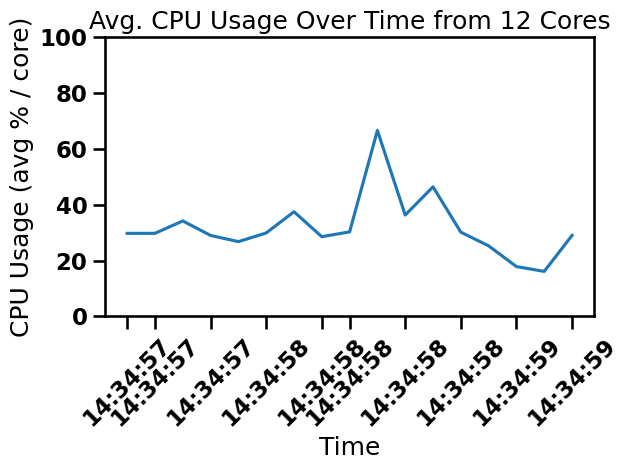

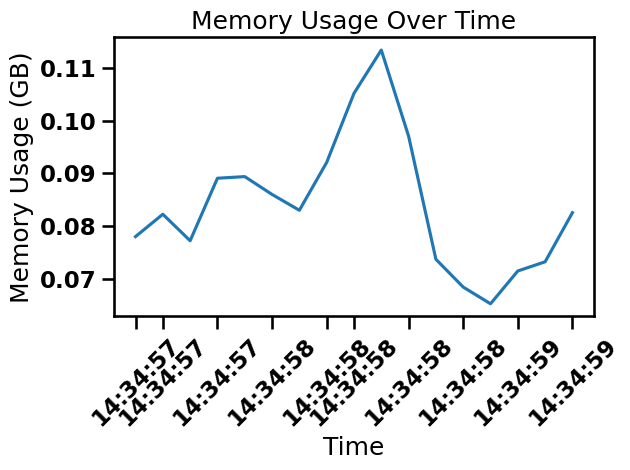

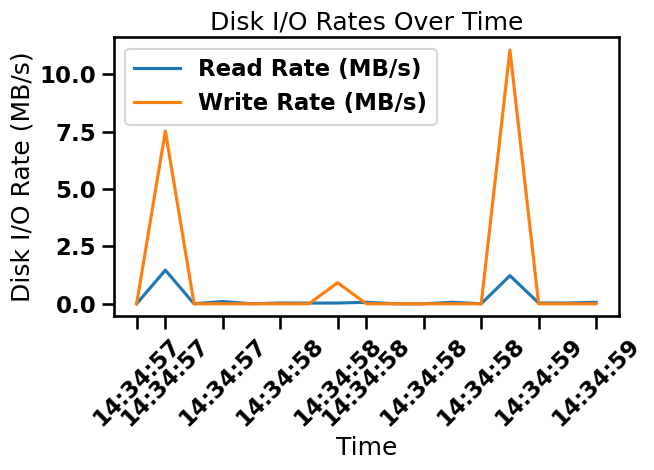

In [108]:
monitor.plot_metrics()

In [116]:
import numpy as np

# The fitted model can be used to create universial embeddings
encoder.load(file_path="best_encoder_weights./best_data_encoder_weights.pth")
encoder2.load(file_path="best_encoder_weights/best_context_encoder_weights.pth")
decoder.load(file_path="best_decoder_weights/best_decoder_weights.pth")
trainer = Trainer(
    encoders={"data_encoder": encoder, "context_encoder": encoder2},
    decoder=decoder,
    encoder_inputs={
        "data_encoder": {"in_main": "d_emb", "in_cross": "c_emb"},
        "context_encoder": {"in_main": "c_emb", "in_cross": "d_emb"},
    },
)
trainer.infer_adata(
    test_adata,
    sample_id_key="soma_joinid",
    seq_length=seq_length,
    batch_size=batch_size,
    chunk_size=seq_length * batch_size,
    output_zarr_path="inferred_adata.zarr",
    n_recon=2,
)

mmcontext.engine.models - INFO - Loading model state dictionary from best_encoder_weights./best_data_encoder_weights.pth
mmcontext.engine.models - INFO - Loading model state dictionary from best_encoder_weights/best_context_encoder_weights.pth
mmcontext.engine.models - INFO - Loading model state dictionary from best_decoder_weights/best_decoder_weights.pth
mmcontext.engine.trainer - INFO - Running on device: cpu


In [119]:
inferred_adata = anndata.read_zarr("inferred_adata.zarr")

In [111]:
inferred_adata.shape

(928, 1000)

#### 4. Evaluate the embeddings
In order to assess the quality of the embeddings, the {class}`mmcontext.eval.scibEvaluator` can be used. It computes metrics from the scib package {cite:p}`luecken2022benchmarking` in order to asess bioconservation and batch integration. This can also be judged visualy with a umap.

In [74]:
# Different random realizations of the reconstructed data are stored in the layers of the inferred_adata object
inferred_adata.layers

Layers with keys: reconstructed1, reconstructed2

In [78]:
from mmcontext.pl.plotting import plot_umap
from mmcontext.eval import scibEvaluator

# Initialize scibEvaluator
evaluator = scibEvaluator(
    adata=inferred_adata,
    batch_key="dataset_id",
    label_key="cell_type",
    embedding_key=["scvi", "data_encoder_mod_emb", "context_encoder_mod_emb"],
    reconstructed_keys=list(inferred_adata.layers),
    max_cells=2000,  # subsample cells for faster computation
)

In [79]:
from mmcontext.eval.system_usage import SystemMonitor

res = evaluator.evaluate()

mmcontext.eval.evaluate_scib - INFO - Computing metrics on raw data...
mmcontext.eval.evaluate_scib - INFO - Computing PCA on all genes...
resolution: 0.1, nmi: 0.3622205424196693
resolution: 0.2, nmi: 0.4563503450815188
resolution: 0.3, nmi: 0.5188875811999084
resolution: 0.4, nmi: 0.5697609874505798
resolution: 0.5, nmi: 0.5754588663557613
resolution: 0.6, nmi: 0.5897712539906428
resolution: 0.7, nmi: 0.6024561352817863
resolution: 0.8, nmi: 0.6232229676853134
resolution: 0.9, nmi: 0.6306581867469876
resolution: 1.0, nmi: 0.6300797213693463
resolution: 1.1, nmi: 0.6379909121607001
resolution: 1.2, nmi: 0.6361243219494015
resolution: 1.3, nmi: 0.6352313795597236
resolution: 1.4, nmi: 0.6485586838858101
resolution: 1.5, nmi: 0.6485586838858101
resolution: 1.6, nmi: 0.6443415060839481
resolution: 1.7, nmi: 0.6507215038851186
resolution: 1.8, nmi: 0.6507215038851186
resolution: 1.9, nmi: 0.6506287192579358
resolution: 2.0, nmi: 0.6507215038851187
optimised clustering against cell_type
op

C:\Users\mengerj\AppData\Local\Programs\Python\Python310\lib\tempfile.py:860: ResourceWarning: Implicitly cleaning up <TemporaryDirectory 'C:\\Users\\mengerj\\AppData\\Local\\Temp\\lisi_fw5j2ov7'>
  _warnings.warn(warn_message, ResourceWarning)
C:\Users\mengerj\AppData\Local\Programs\Python\Python310\lib\tempfile.py:860: ResourceWarning: Implicitly cleaning up <TemporaryDirectory 'C:\\Users\\mengerj\\AppData\\Local\\Temp\\lisi_8t9spjkp'>
  _warnings.warn(warn_message, ResourceWarning)
C:\Users\mengerj\AppData\Local\Programs\Python\Python310\lib\tempfile.py:860: ResourceWarning: Implicitly cleaning up <TemporaryDirectory 'C:\\Users\\mengerj\\AppData\\Local\\Temp\\lisi_uxxkio5s'>
  _warnings.warn(warn_message, ResourceWarning)


resolution: 0.1, nmi: 0.0
resolution: 0.2, nmi: 0.0
resolution: 0.3, nmi: 0.016385062775449467
resolution: 0.4, nmi: 0.025893605687517387
resolution: 0.5, nmi: 0.04816013754313803
resolution: 0.6, nmi: 0.06029171948202093
resolution: 0.7, nmi: 0.07616704152170109
resolution: 0.8, nmi: 0.08661138108799854
resolution: 0.9, nmi: 0.10786705182449902
resolution: 1.0, nmi: 0.1297137653440677
resolution: 1.1, nmi: 0.14526121820871432
resolution: 1.2, nmi: 0.14839135231355777
resolution: 1.3, nmi: 0.15706752934623186
resolution: 1.4, nmi: 0.1571473133118102
resolution: 1.5, nmi: 0.17143500465833453
resolution: 1.6, nmi: 0.17449574455267938
resolution: 1.7, nmi: 0.19108192956156037
resolution: 1.8, nmi: 0.19035229665105285
resolution: 1.9, nmi: 0.19820866054320646
resolution: 2.0, nmi: 0.19381789864165896
optimised clustering against cell_type
optimal cluster resolution: 1.9
optimal score: 0.19820866054320646
isolated labels: no more than 1 batches per label
isolated labels: no more than 1 batc

C:\Users\mengerj\AppData\Local\Programs\Python\Python310\lib\tempfile.py:860: ResourceWarning: Implicitly cleaning up <TemporaryDirectory 'C:\\Users\\mengerj\\AppData\\Local\\Temp\\lisi_fqdj2f69'>
  _warnings.warn(warn_message, ResourceWarning)
C:\Users\mengerj\AppData\Local\Programs\Python\Python310\lib\tempfile.py:860: ResourceWarning: Implicitly cleaning up <TemporaryDirectory 'C:\\Users\\mengerj\\AppData\\Local\\Temp\\lisi__kykuo1y'>
  _warnings.warn(warn_message, ResourceWarning)
C:\Users\mengerj\AppData\Local\Programs\Python\Python310\lib\tempfile.py:860: ResourceWarning: Implicitly cleaning up <TemporaryDirectory 'C:\\Users\\mengerj\\AppData\\Local\\Temp\\lisi_vg11z0zv'>
  _warnings.warn(warn_message, ResourceWarning)
C:\Users\mengerj\AppData\Local\Programs\Python\Python310\lib\tempfile.py:860: ResourceWarning: Implicitly cleaning up <TemporaryDirectory 'C:\\Users\\mengerj\\AppData\\Local\\Temp\\lisi_dc0y5d2x'>
  _warnings.warn(warn_message, ResourceWarning)
C:\Users\mengerj\App

kidney epithelial cell: 0.9473684210526315
Compute neighbors on rep data_encoder_mod_emb
luminal adaptive secretory precursor cell of mammary gland: 0.32558139534883723
Compute neighbors on rep data_encoder_mod_emb
luminal epithelial cell of mammary gland: 0.13793103448275862
Compute neighbors on rep data_encoder_mod_emb
mature NK T cell: 0.22784810126582278
Compute neighbors on rep data_encoder_mod_emb
mature T cell: 0.1411764705882353
Compute neighbors on rep data_encoder_mod_emb
mesenchymal cell: 0.07272727272727272
Compute neighbors on rep data_encoder_mod_emb
myeloid cell: 0.5074626865671642
Compute neighbors on rep data_encoder_mod_emb
myoepithelial cell of mammary gland: 0.22950819672131148
Compute neighbors on rep data_encoder_mod_emb
neoplastic cell: 0.14634146341463414
Compute neighbors on rep data_encoder_mod_emb
neural cell: 0.6486486486486487
Compute neighbors on rep data_encoder_mod_emb
perivascular cell: 0.2777777777777778
Compute neighbors on rep data_encoder_mod_emb
py

In [80]:
res

,data_id,hvg,type,ARI,NMI,ASW,Isolated_Labels_ASW,Isolated_Labels_F1,Bio_Conservation_Score,Silhouette_Batch,Graph_Connectivity,Batch_Integration_Score,Overall_Score
0,,None,raw,0.319397,0.650722,0.412581,0.508366,0.363206,0.450854,0.712724,0.889386,0.801055,0.590935
1,,None,reconstructed1,-0.001102,0.177398,0.435318,0.439518,0.114639,0.233154,0.879405,0.239613,0.559509,0.363696
2,,None,reconstructed2,0.000448,0.198209,0.416072,0.425415,0.130031,0.234035,0.889953,0.266225,0.578089,0.371656
3,,None,embedding_scvi,0.388573,0.701891,0.507724,0.552753,0.362576,0.502703,0.797206,0.912457,0.854832,0.643555
4,,None,embedding_data_encoder_mod_emb,0.403889,0.690134,0.505978,0.547546,0.399302,0.509370,0.788198,0.914519,0.851359,0.646165
5,,None,embedding_context_encoder_mod_emb,0.403889,0.690134,0.505978,0.547546,0.399302,0.509370,0.788198,0.914519,0.851359,0.646165


We can also compare the reconstructed matrix and the original matrix. We do this by computing a variety of data properties and comparing them between orignal and reconstructed data

In [82]:
# Initialize the DataProperties object
from mmcontext.eval import DataProperties

dp = DataProperties(predefined_subset="microbiome")

In [122]:
dp.add_original_data(test_adata.X.toarray())

mmcontext.eval.data_properties - INFO - Using predefined microbiome subset.
mmcontext.eval.data_properties - WARNING - Warning computing bimodalityColCorr: invalid value encountered in divide
mmcontext.eval.data_properties - WARNING - Warning computing bimodalityColCorr: invalid value encountered in divide
mmcontext.eval.data_properties - WARNING - Warning computing meanColCorr: invalid value encountered in divide
mmcontext.eval.data_properties - WARNING - Warning computing meanColCorr: invalid value encountered in divide
mmcontext.eval.data_properties - WARNING - Warning computing sdColCorr: An input array is constant; the correlation coefficient is not defined.
mmcontext.eval.data_properties - WARNING - Warning computing sdColCorr: Degrees of freedom <= 0 for slice.


In [84]:
# Add reconstructed data to DataProperties object
for reconstructed_data in inferred_adata.layers:
    dp.add_reconstructed_data(inferred_adata.layers[reconstructed_data])

mmcontext.eval.data_properties - INFO - Using predefined microbiome subset.
mmcontext.eval.data_properties - WARNING - Warning computing bimodalityColCorr: invalid value encountered in divide
mmcontext.eval.data_properties - WARNING - Warning computing bimodalityColCorr: invalid value encountered in divide
mmcontext.eval.data_properties - WARNING - Warning computing meanColCorr: An input array is constant; the correlation coefficient is not defined.
mmcontext.eval.data_properties - WARNING - Warning computing meanColCorr: Mean of empty slice
mmcontext.eval.data_properties - WARNING - Warning computing sdColCorr: invalid value encountered in divide
mmcontext.eval.data_properties - WARNING - Warning computing sdColCorr: invalid value encountered in divide
mmcontext.eval.data_properties - INFO - Using predefined microbiome subset.
mmcontext.eval.data_properties - WARNING - Warning computing bimodalityColCorr: invalid value encountered in divide
mmcontext.eval.data_properties - WARNING - W

In [85]:
# simulate new data and perform the same procedure
# This could be a different test dataset
test_adata2 = test_adata.copy()
test_adata2.X += np.random.normal(0, 1e-6, size=test_adata2.X.shape)
dp.add_original_data(test_adata.X.toarray())

mmcontext.eval.data_properties - INFO - Using predefined microbiome subset.


c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\anndata\_core\storage.py:85: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)


mmcontext.eval.data_properties - WARNING - Warning computing bimodalityColCorr: invalid value encountered in divide
mmcontext.eval.data_properties - WARNING - Warning computing bimodalityColCorr: invalid value encountered in divide
mmcontext.eval.data_properties - WARNING - Warning computing meanColCorr: An input array is constant; the correlation coefficient is not defined.
mmcontext.eval.data_properties - WARNING - Warning computing meanColCorr: Mean of empty slice
mmcontext.eval.data_properties - WARNING - Warning computing sdColCorr: invalid value encountered in divide
mmcontext.eval.data_properties - WARNING - Warning computing sdColCorr: invalid value encountered in divide


In [86]:
trainer.infer_adata(
    test_adata2,
    sample_id_key="soma_joinid",
    seq_length=seq_length,
    batch_size=batch_size,
    chunk_size=seq_length * batch_size,
    output_zarr_path="inferred_adata.zarr",
    n_recon=2,
)
inferred_adata2 = anndata.read_zarr("inferred_adata.zarr")

In [87]:
for reconstructed_data in inferred_adata2.layers:
    dp.add_reconstructed_data(inferred_adata2.layers[reconstructed_data])

mmcontext.eval.data_properties - INFO - Using predefined microbiome subset.
mmcontext.eval.data_properties - WARNING - Warning computing bimodalityColCorr: invalid value encountered in divide
mmcontext.eval.data_properties - WARNING - Warning computing bimodalityColCorr: invalid value encountered in divide
mmcontext.eval.data_properties - WARNING - Warning computing meanColCorr: invalid value encountered in divide
mmcontext.eval.data_properties - WARNING - Warning computing meanColCorr: invalid value encountered in divide
mmcontext.eval.data_properties - WARNING - Warning computing sdColCorr: invalid value encountered in divide
mmcontext.eval.data_properties - WARNING - Warning computing sdColCorr: invalid value encountered in divide
mmcontext.eval.data_properties - INFO - Using predefined microbiome subset.
mmcontext.eval.data_properties - WARNING - Warning computing bimodalityColCorr: invalid value encountered in divide
mmcontext.eval.data_properties - WARNING - Warning computing bim

In [88]:
dp.compare_data_properties()

,id,recon_id,nFeatures,sdp0Col,coefHclustRows,medianColSums,QuadCoefPoly2,sdColCorr,corrColSumsP0Sample,sdRowMeansLog2cpm,...,medianRowMediansLog2cpm,nSamples,sdRowCorr,meanColSums,sdp0Row,meanRowVarsLog2cpm,bimodalityColCorr,meanRowCorr,minColSums,meanLog2FC
0,0,0,0.0,0.104749,0.078646,0.615525,-2.219304,0.276785,-0.007922,1.625317,...,0.0,0.0,1.152913,0.067290,1.644669,0.190243,NaN,0.325894,0.0,0.413200
1,0,1,0.0,0.114136,0.100096,0.602925,-1.820998,0.286754,-0.007336,1.654004,...,0.0,0.0,1.150202,0.065517,1.668740,0.194520,NaN,0.349622,0.0,0.475995
2,1,0,0.0,0.112891,0.065390,0.590214,-2.765168,0.287076,-0.009395,1.587334,...,0.0,0.0,1.123019,0.073251,1.605182,0.190900,1.937688,0.419105,0.0,0.543648
3,1,1,0.0,0.117931,0.083281,0.628016,-1.238817,0.290132,-0.006138,1.631045,...,0.0,0.0,1.136035,0.063883,1.645920,0.191210,0.763577,0.441449,0.0,0.459512


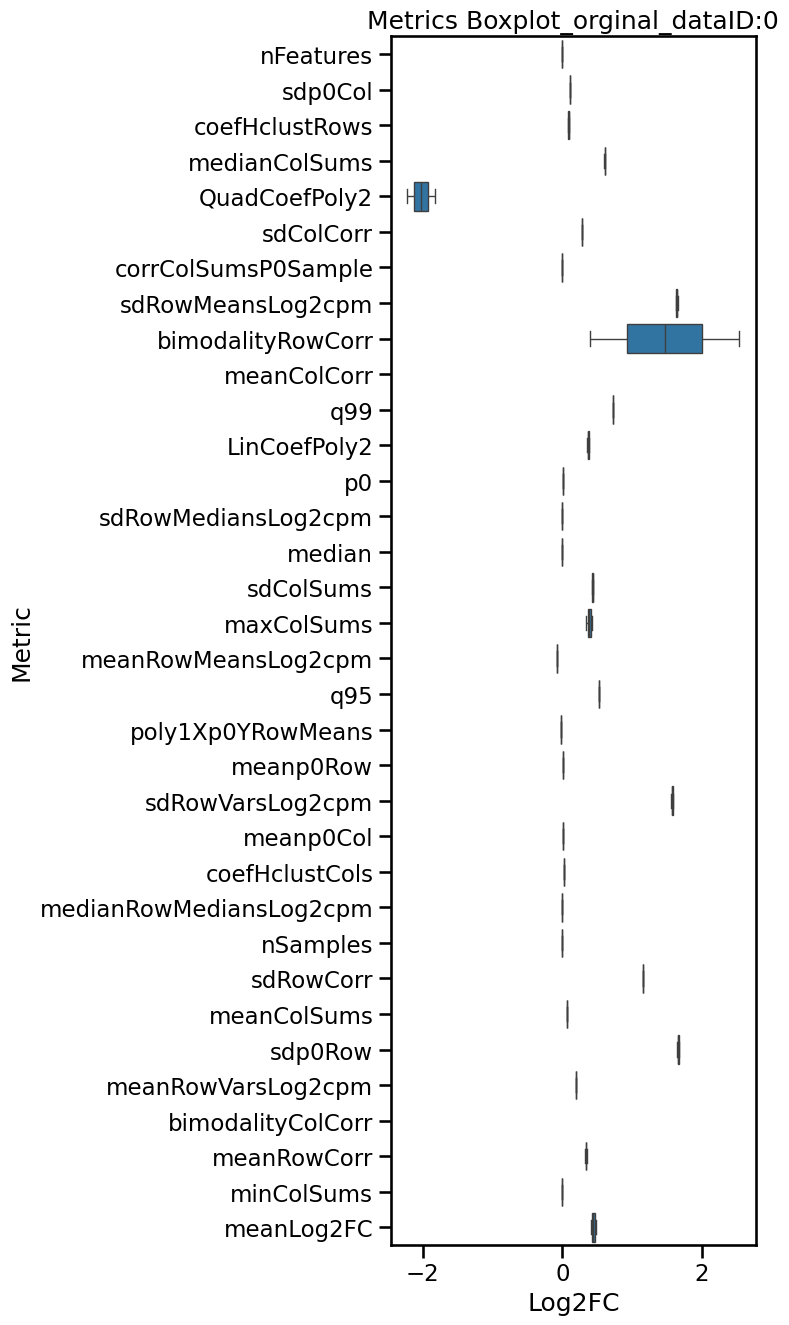

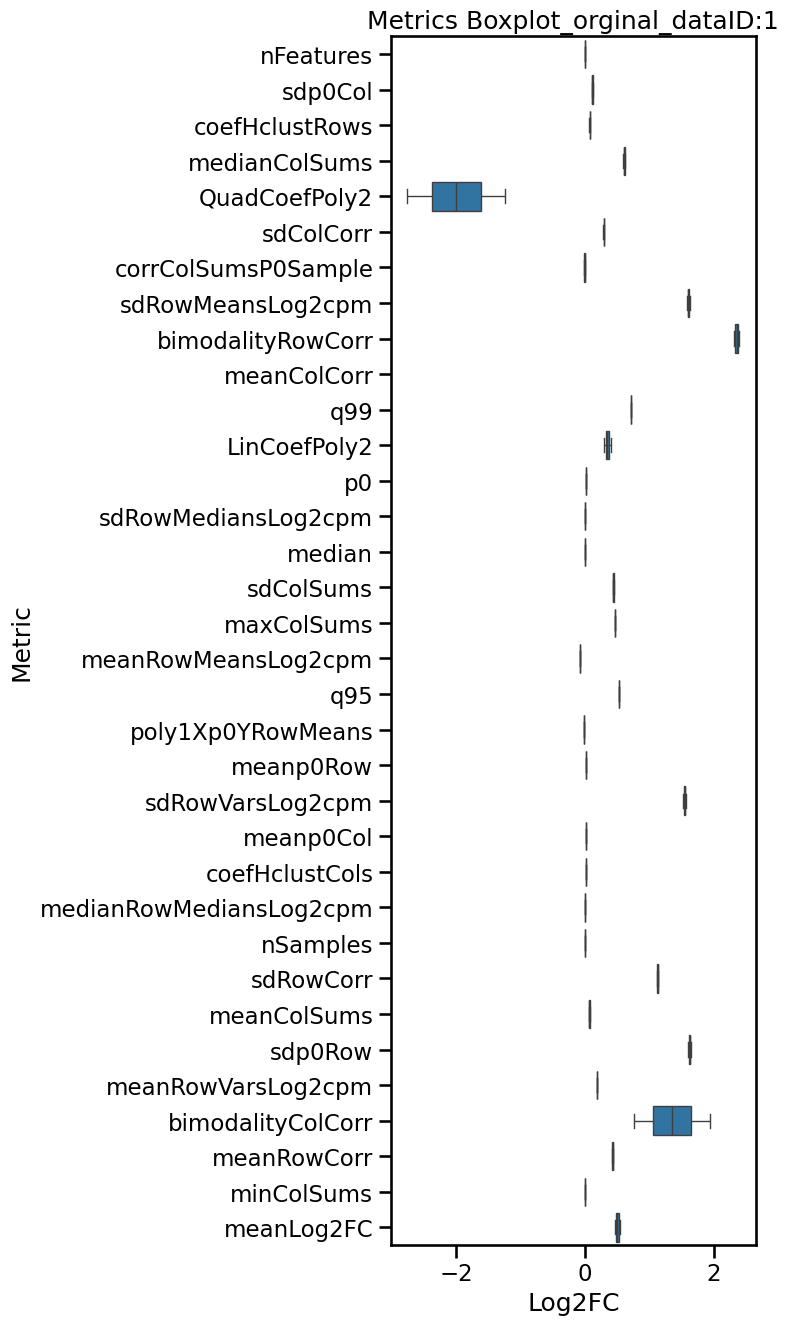

In [89]:
dp.plot_metrics()

mmcontext.eval.data_properties - WARNING - Property PCA Plot: Dropped columns with NaN values: {'meanColCorr', 'bimodalityColCorr'}


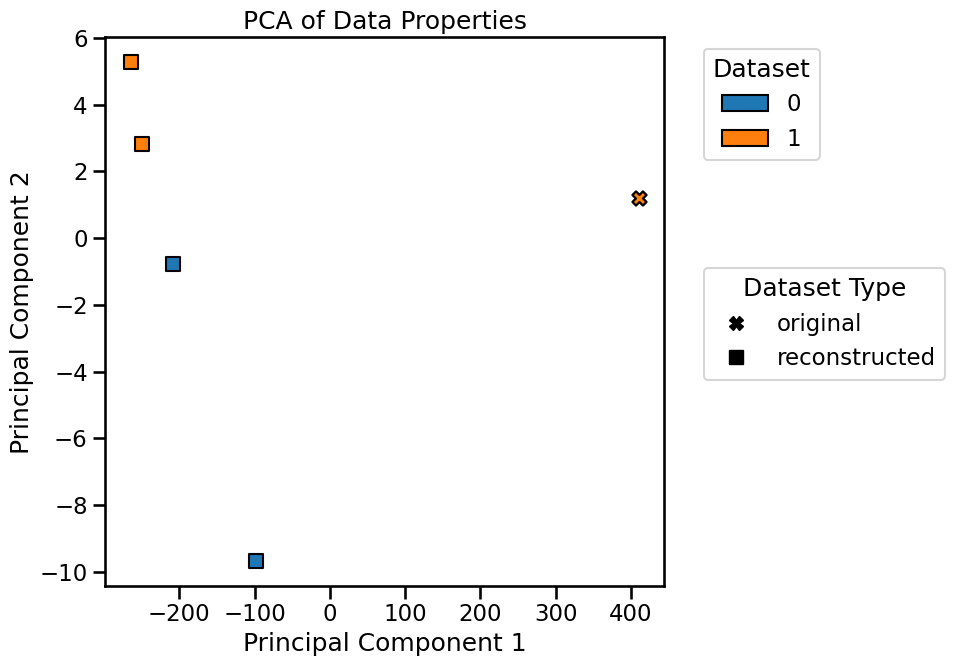

In [90]:
dp.plot_pca()

mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.


<Figure size 800x800 with 0 Axes>

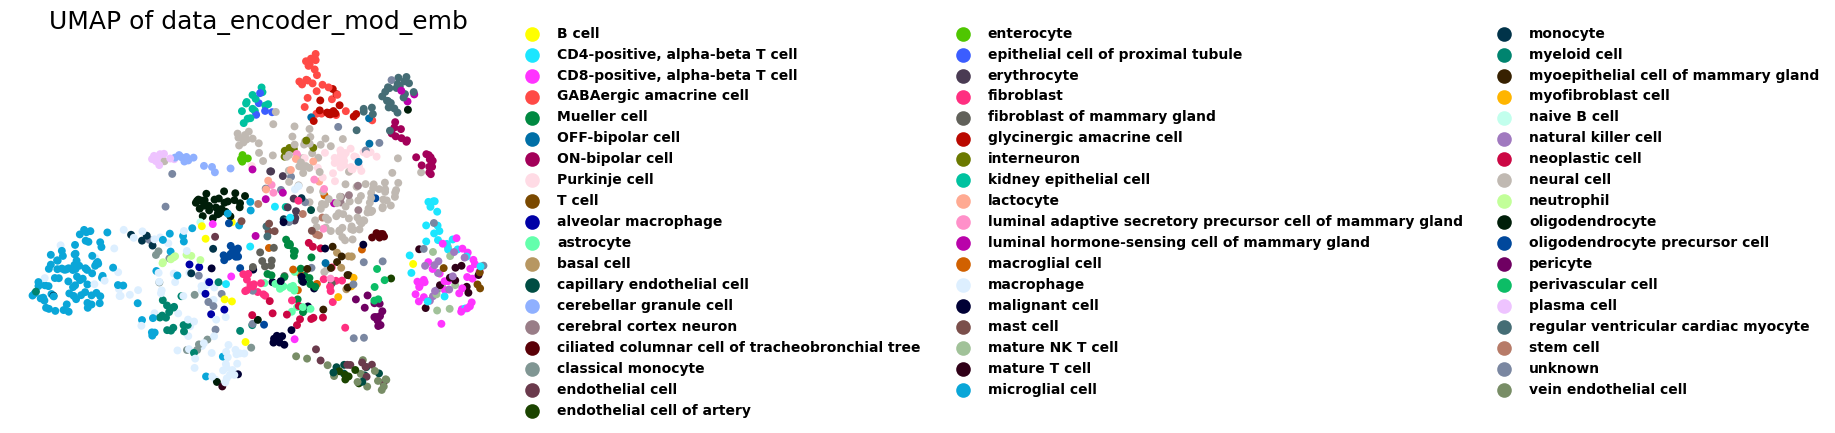

mmcontext.pl.plotting - INFO - Displayed UMAP plot interactively.


In [117]:
plot_umap(inferred_adata, color_group="cell_type", embedding_key="data_encoder_mod_emb", save_plot=False)

mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.


c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\scipy\sparse\_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


<Figure size 800x800 with 0 Axes>

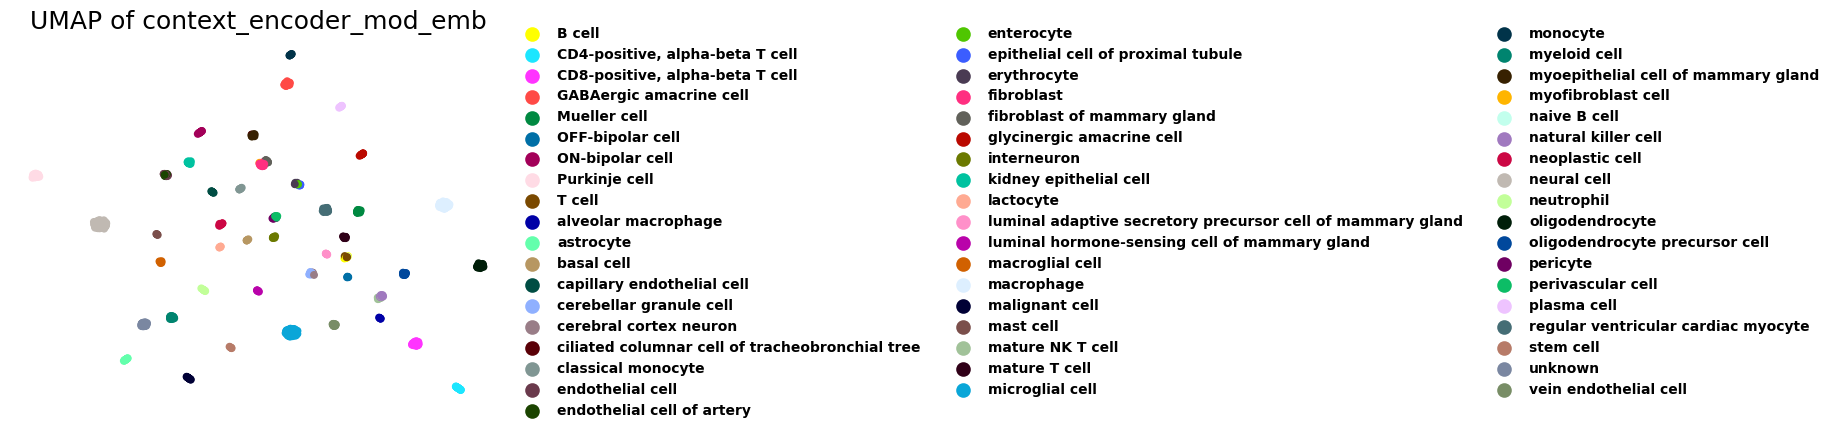

mmcontext.pl.plotting - INFO - Displayed UMAP plot interactively.


In [120]:
plot_umap(
    inferred_adata, color_group="cell_type", embedding_key="context_encoder_mod_emb", save_plot=False, sample_size=1000
)

mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.


<Figure size 800x800 with 0 Axes>

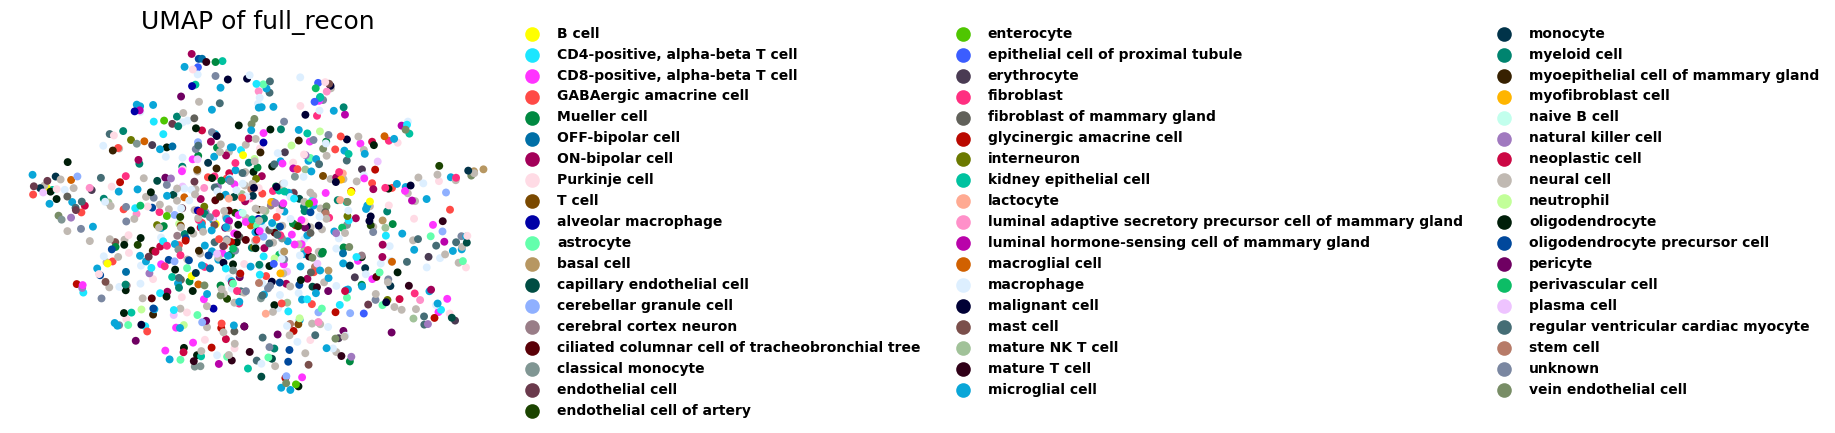

mmcontext.pl.plotting - INFO - Displayed UMAP plot interactively.


In [121]:
inferred_adata.obsm["full_recon"] = inferred_adata.layers["reconstructed1"]
plot_umap(inferred_adata, color_group="cell_type", embedding_key="full_recon", sample_size=1000)